# LOGOTS
Transformation layer notebook

In [2]:
import pandas as pd
import numpy as np
from scipy.fftpack import fft, fftfreq
import time
import ast
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.signal import spectrogram

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Audio Transformations

## 1. Upload CSVs

In [6]:
stg_audio_data = pd.read_csv("stg_audio_data.csv")

In [7]:
# Convert `audio_samples` column from string to list
stg_audio_data['audio_samples'] = stg_audio_data['audio_samples'].apply(ast.literal_eval)

In [8]:
stg_audio_data.head(10)

,frame_id,timestamp,audio_samples
0,0,2025-03-08 19:27:45.190028,"[-847, -847, -1412, -1412, -847, -847, 282, 28..."
1,1,2025-03-08 19:27:45.214157,"[2259, 2259, 847, 847, 282, 282, 847, 847, 847..."
2,2,2025-03-08 19:27:45.238556,"[1129, 1129, 564, 564, -282, -282, -1129, -112..."
3,3,2025-03-08 19:27:45.253324,"[2259, 2259, 2542, 2542, 1977, 1977, 1412, 141..."
4,4,2025-03-08 19:27:45.277067,"[-564, -564, -2259, -2259, -3107, -3107, -1694..."
5,5,2025-03-08 19:27:45.295292,"[-1129, -1129, -1694, -1694, -1412, -1412, -14..."
6,6,2025-03-08 19:27:45.394539,"[-3954, -3954, -3107, -3107, -4802, -4802, -33..."
7,7,2025-03-08 19:27:45.590315,"[-1129, -1129, -3107, -3107, -4237, -4237, -39..."
8,8,2025-03-08 19:27:45.788189,"[847, 847, -847, -847, -282, -282, -282, -282,..."
9,9,2025-03-08 19:27:45.981544,"[-1412, -1412, -564, -564, -2824, -2824, -2824..."


## 2. Define Transformation Functions

In [10]:
def compute_fft(samples, sampling_rate=8000):
    """
    Computes the FFT for the given audio samples.

    Parameters:
        samples (list or np.array): Audio samples.
        sampling_rate (int): Sampling rate of the audio.

    Returns:
        dict: A dictionary with 'freqs' and 'magnitudes'.
    """
    samples = np.array(samples)
    n = len(samples)
    freqs = np.fft.rfftfreq(n, d=1/sampling_rate)
    fft_values = np.abs(np.fft.rfft(samples))
    return {"freqs": freqs, "magnitudes": fft_values}

def classify_voice_or_noise(freqs, magnitudes, voice_freq_range=(500, 3500), energy_threshold=15000000):
    """
    Classifies whether the given frequencies and magnitudes represent a voice or noise.

    Parameters:
        freqs (list or np.array): Frequencies from the FFT.
        magnitudes (list or np.array): Corresponding magnitudes for the frequencies.
        voice_freq_range (tuple): The frequency range considered as 'voice'. Default is (85, 255) Hz.
        energy_threshold (float): The minimum energy (sum of magnitudes in the range) to classify as voice.

    Returns:
        str: 'Voice' if the input is classified as voice, 'Noise' otherwise.
    """
    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Find indices within the voice frequency range
    voice_indices = (freqs >= voice_freq_range[0]) & (freqs <= voice_freq_range[1])

    # Calculate total energy in the voice frequency range
    voice_energy = np.sum(magnitudes[voice_indices])

    # Classify based on energy threshold
    if voice_energy > energy_threshold:
        return "Voice"
    else:
        return "Noise"
        

def detect_cat_voice(classification, freqs, magnitudes, freq_range=(400, 700), harmonic_range=(200, 1000), harmonic_threshold=15):
    """
    Determines if the detected voice is a cat's voice based on spectral peaks and harmonic energy.

    Parameters:
        classification (str): The classification ('Voice' or 'Noise').
        freqs (list or np.array): Frequencies from the FFT result.
        magnitudes (list or np.array): Magnitudes corresponding to the frequencies.
        freq_range (tuple): Frequency range for a cat's voice.
        harmonic_range (tuple): Frequency range for detecting harmonics.
        harmonic_threshold (float): Ratio of harmonic energy to primary peak magnitude to classify as human.

    Returns:
        int: 1 if the detected voice is a cat's voice, 0 otherwise.
    """
    if classification != "Voice":
        return 0

    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Select frequencies and magnitudes within the primary range (cat voice range)
    primary_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    primary_freqs = freqs[primary_mask]
    primary_magnitudes = magnitudes[primary_mask]

    if len(primary_freqs) == 0 or len(primary_magnitudes) == 0:
        return 0  # No energy in the cat's voice range

    # Find the primary peak (highest magnitude in the primary range)
    primary_peak_magnitude = primary_magnitudes.max()

    # Check for harmonics in the harmonic range
    harmonic_mask = (freqs >= harmonic_range[0]) & (freqs <= harmonic_range[1])
    harmonic_magnitudes = magnitudes[harmonic_mask]

    # Calculate total harmonic energy
    harmonic_energy = np.sum(harmonic_magnitudes)

    # Classify as a cat's voice if harmonic energy is low relative to the primary peak
    if harmonic_energy / primary_peak_magnitude < harmonic_threshold:
        return 1  # Cat's voice detected

    return 0  # Not a cat's voice

def detect_human_voice(classification, freqs, magnitudes, freq_range=(150, 600), harmonic_range=(2000, 4000), harmonic_threshold=15):
    """
    Determines if the detected voice is a human's voice based on normalized average of squared magnitudes
    and harmonic energy analysis.

    Parameters:
        classification (str): The classification ('Voice' or 'Noise').
        freqs (list or np.array): Frequencies from the FFT result.
        magnitudes (list or np.array): Magnitudes corresponding to the frequencies.
        freq_range (tuple): Frequency range for a human's voice.
        harmonic_range (tuple): Frequency range to detect harmonic energy for human voices.
        harmonic_threshold (float): Threshold for detecting significant harmonic energy.

    Returns:
        int: 1 if the detected voice is a human's voice, 0 otherwise.
    """
    if classification != "Voice":
        return 0

    # Convert to numpy arrays for efficient computation
    freqs = np.array(freqs)
    magnitudes = np.array(magnitudes)

    # Select frequencies and magnitudes within the primary human voice range
    primary_mask = (freqs >= freq_range[0]) & (freqs <= freq_range[1])
    primary_magnitudes = magnitudes[primary_mask]

    if len(primary_magnitudes) == 0:
        return 0

    # Calculate normalized average squared magnitude within the primary range
    primary_energy = np.mean(primary_magnitudes**2) / np.max(magnitudes**2)

    # Select frequencies and magnitudes within the harmonic range
    harmonic_mask = (freqs >= harmonic_range[0]) & (freqs <= harmonic_range[1])
    harmonic_magnitudes = magnitudes[harmonic_mask]

    if len(harmonic_magnitudes) == 0:
        return 0

    # Calculate total harmonic energy
    harmonic_energy = np.sum(harmonic_magnitudes)

    # Detect human voice if primary energy and harmonic energy exceed thresholds
    if primary_energy > 0.1 and harmonic_energy > harmonic_threshold:
        return 1

    return 0

def calculate_meow_loudness(is_cat_voice, magnitudes):
    """
    Buckets the loudness of a meow into 'low', 'medium', or 'high' if is_cat_voice is True.

    Parameters:
        is_cat_voice (int): 1 if it's a cat's voice, 0 otherwise.
        magnitudes (list): Magnitudes corresponding to the FFT result.

    Returns:
        str: 'low', 'medium', or 'high' if is_cat_voice is True; 'none' otherwise.
    """
    if is_cat_voice != 1:
        return "none"  # Not a cat's voice
    
    # Calculate the average loudness from magnitudes
    avg_loudness = np.mean(magnitudes)

    # Define thresholds for loudness buckets
    if avg_loudness < 40000:  # Threshold for low loudness
        return "low"
    elif 40000 <= avg_loudness <= 60000:  # Threshold for medium loudness
        return "medium"
    else:  # Threshold for high loudness
        return "high"

def calculate_dominant_frequency(freqs, magnitudes):
    """
    Calculates the dominant frequency from the FFT results.

    Parameters:
        freqs (list or array): List or array of frequencies from the FFT result.
        magnitudes (list or array): Corresponding magnitudes for the frequencies.

    Returns:
        float: The frequency with the highest magnitude.
    """
    # Check if freqs or magnitudes are empty
    if freqs.size == 0 or magnitudes.size == 0:
        return 0  # Return 0 if no frequencies or magnitudes are present

    # Find the index of the maximum magnitude
    max_index = np.argmax(magnitudes)

    # Return the frequency corresponding to the max magnitude
    return freqs[max_index]

In [11]:
# Timing function
def measure_time(func, *args, **kwargs):
    """
    Measures the execution time of a function.

    Parameters:
        func (callable): Function to be executed.
        *args: Positional arguments for the function.
        **kwargs: Keyword arguments for the function.

    Returns:
        tuple: (result, execution_time_in_seconds)
    """
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

## 3. Execute functions

In [13]:
new_dataframe = stg_audio_data[['frame_id', 'timestamp']]

In [14]:
# 1. Compute FFT and time it
new_dataframe["fft_result"], fft_time = measure_time(
    lambda: stg_audio_data["audio_samples"].apply(compute_fft)
)
print(f"FFT computation time: {fft_time:.6f} seconds")

# 2. Classify voice or noise and time it
new_dataframe["classification"], classification_time = measure_time(
    lambda: new_dataframe["fft_result"].apply(
        lambda x: classify_voice_or_noise(x["freqs"], x["magnitudes"])
    )
)
print(f"Voice/Noise classification time: {classification_time:.6f} seconds")

# 3. Detect cat voice and time it
new_dataframe["is_cat_voice"], cat_voice_time = measure_time(
    lambda: new_dataframe.apply(
        lambda row: detect_cat_voice(
            row["classification"], row["fft_result"]["freqs"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Cat voice detection time: {cat_voice_time:.6f} seconds")

# 4. Detect human voice and time it
new_dataframe["is_human_voice"], human_voice_time = measure_time(
    lambda: new_dataframe.apply(
        lambda row: detect_human_voice(
            row["classification"], row["fft_result"]["freqs"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Human voice detection time: {human_voice_time:.6f} seconds")

# 5. Calculate meow loudness and time it
new_dataframe["meow_loudness"], meow_loudness_time = measure_time(
    lambda: new_dataframe.apply(
        lambda row: calculate_meow_loudness(
            row["is_cat_voice"], row["fft_result"]["magnitudes"]
        ),
        axis=1
    )
)
print(f"Meow loudness calculation time: {meow_loudness_time:.6f} seconds")

# 6. Calculate dominant frequency and time it
new_dataframe["dominant_frequency"], dominant_frequency_time = measure_time(
    lambda: new_dataframe["fft_result"].apply(
        lambda x: calculate_dominant_frequency(x["freqs"], x["magnitudes"])
    )
)
print(f"Dominant frequency calculation time: {dominant_frequency_time:.6f} seconds")

FFT computation time: 0.006786 seconds
Voice/Noise classification time: 0.001015 seconds
Cat voice detection time: 0.000857 seconds
Human voice detection time: 0.000829 seconds
Meow loudness calculation time: 0.000548 seconds
Dominant frequency calculation time: 0.000234 seconds


In [15]:
new_dataframe.head(50)

,frame_id,timestamp,fft_result,classification,is_cat_voice,is_human_voice,meow_loudness,dominant_frequency
0,0,2025-03-08 19:27:45.190028,"{'freqs': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 3...",Noise,0,0,none,20.0
1,1,2025-03-08 19:27:45.214157,"{'freqs': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 3...",Noise,0,0,none,100.0
2,2,2025-03-08 19:27:45.238556,"{'freqs': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 3...",Noise,0,0,none,25.0
3,3,2025-03-08 19:27:45.253324,"{'freqs': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 3...",Noise,0,0,none,25.0
4,4,2025-03-08 19:27:45.277067,"{'freqs': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 3...",Noise,0,0,none,25.0
5,5,2025-03-08 19:27:45.295292,"{'freqs': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 3...",Noise,0,0,none,25.0
6,6,2025-03-08 19:27:45.394539,"{'freqs': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 3...",Noise,0,0,none,30.0
7,7,2025-03-08 19:27:45.590315,"{'freqs': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 3...",Noise,0,0,none,30.0
8,8,2025-03-08 19:27:45.788189,"{'freqs': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 3...",Noise,0,0,none,25.0
9,9,2025-03-08 19:27:45.981544,"{'freqs': [0.0, 5.0, 10.0, 15.0, 20.0, 25.0, 3...",Noise,0,0,none,25.0


## 4. Visualize Data

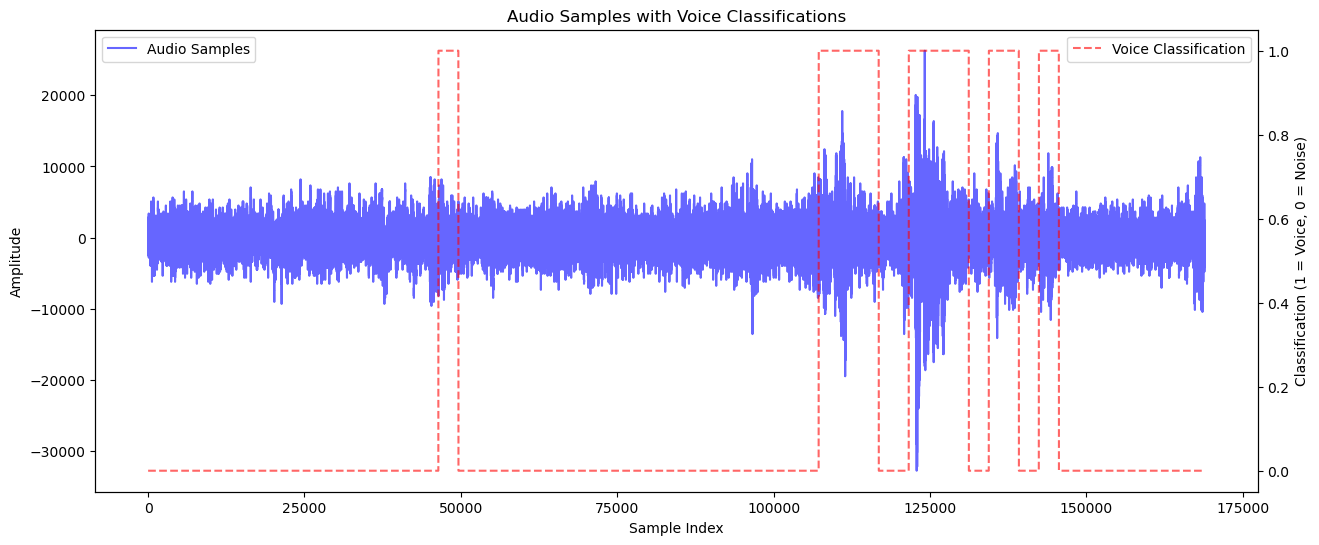

In [17]:
def plot_audio_with_classifications(stg_audio_data, new_dataframe):
    """
    Plots the concatenated audio samples with voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        new_dataframe (pd.DataFrame): DataFrame containing `frame_id` and `classification`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the classifications to align with the concatenated audio
    classifications = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get classification for the frame from new_dataframe
        classification = new_dataframe.loc[
            new_dataframe["frame_id"] == frame_id, "classification"
        ].values
        if len(classification) > 0:
            classifications.append(1 if classification[0] == "Voice" else 0)
        else:
            classifications.append(0)  # Default to 0 if no classification

    # Expand classifications to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_classifications = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_classifications.extend([classifications[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_classifications, label="Voice Classification", color="red", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Voice, 0 = Noise)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_classifications(stg_audio_data, new_dataframe)

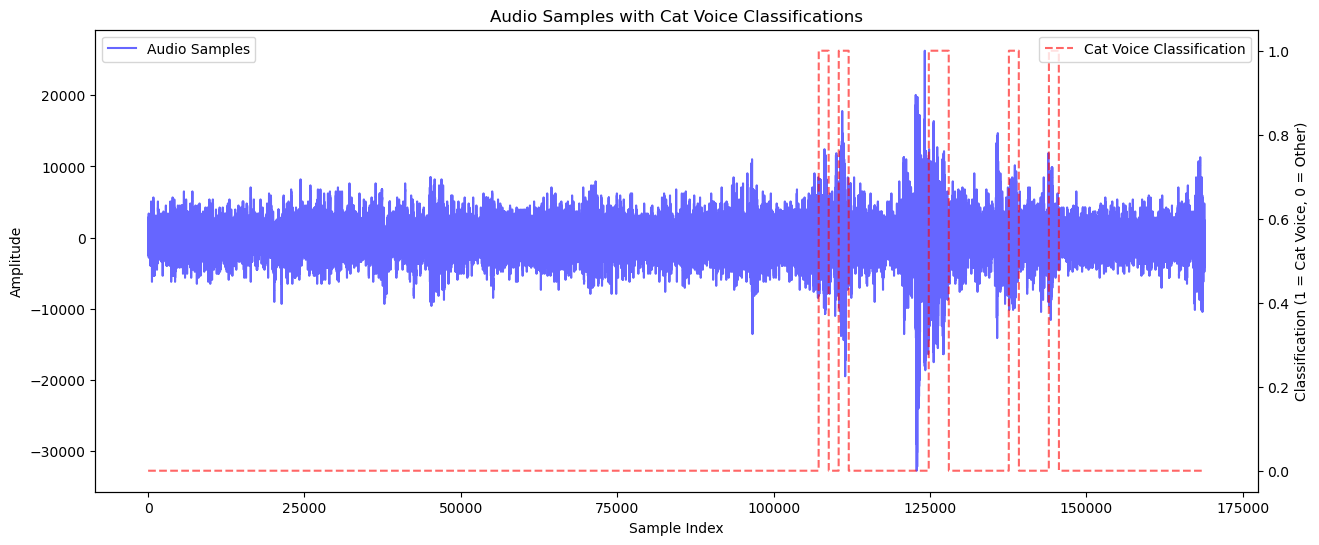

In [18]:
def plot_audio_with_cat_voice(stg_audio_data, new_dataframe):
    """
    Plots the concatenated audio samples with cat voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        new_dataframe (pd.DataFrame): DataFrame containing `frame_id` and `is_cat_voice`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the is_cat_voice values to align with the concatenated audio
    cat_voice_flags = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get is_cat_voice for the frame from new_dataframe
        is_cat_voice = new_dataframe.loc[
            new_dataframe["frame_id"] == frame_id, "is_cat_voice"
        ].values
        if len(is_cat_voice) > 0:
            cat_voice_flags.append(is_cat_voice[0])
        else:
            cat_voice_flags.append(0)  # Default to 0 if no classification

    # Expand cat voice flags to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_cat_voice_flags = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_cat_voice_flags.extend([cat_voice_flags[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot cat voice classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_cat_voice_flags, label="Cat Voice Classification", color="red", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Cat Voice, 0 = Other)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Cat Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_cat_voice(stg_audio_data, new_dataframe)

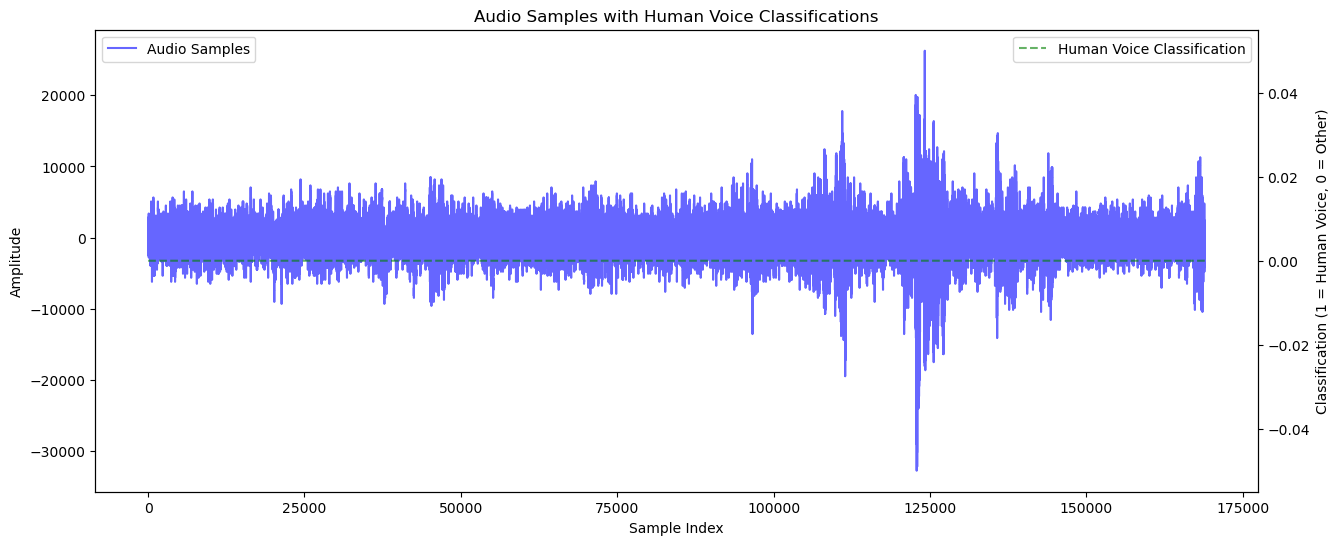

In [19]:
def plot_audio_with_human_voice(stg_audio_data, new_dataframe):
    """
    Plots the concatenated audio samples with human voice classifications on a secondary y-axis.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing `frame_id` and `audio_samples`.
        new_dataframe (pd.DataFrame): DataFrame containing `frame_id` and `is_human_voice`.
    """
    # Concatenate all audio samples into a single array
    concatenated_samples = []
    for samples in stg_audio_data["audio_samples"]:
        concatenated_samples.extend(samples)

    # Prepare the is_human_voice values to align with the concatenated audio
    human_voice_flags = []
    for frame_id in stg_audio_data["frame_id"]:
        # Get is_human_voice for the frame from new_dataframe
        is_human_voice = new_dataframe.loc[
            new_dataframe["frame_id"] == frame_id, "is_human_voice"
        ].values
        if len(is_human_voice) > 0:
            human_voice_flags.append(is_human_voice[0])
        else:
            human_voice_flags.append(0)  # Default to 0 if no classification

    # Expand human voice flags to match the length of the audio samples for each frame
    samples_per_frame = [len(samples) for samples in stg_audio_data["audio_samples"]]
    expanded_human_voice_flags = []
    for i, samples_count in enumerate(samples_per_frame):
        expanded_human_voice_flags.extend([human_voice_flags[i]] * samples_count)

    # Plot the audio samples
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1.plot(concatenated_samples, label="Audio Samples", color="blue", alpha=0.6)
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Amplitude")
    ax1.legend(loc="upper left")

    # Plot human voice classifications on a secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(expanded_human_voice_flags, label="Human Voice Classification", color="green", alpha=0.6, linestyle="--")
    ax2.set_ylabel("Classification (1 = Human Voice, 0 = Other)")
    ax2.legend(loc="upper right")

    plt.title("Audio Samples with Human Voice Classifications")
    plt.show()

# Usage example:
plot_audio_with_human_voice(stg_audio_data, new_dataframe)

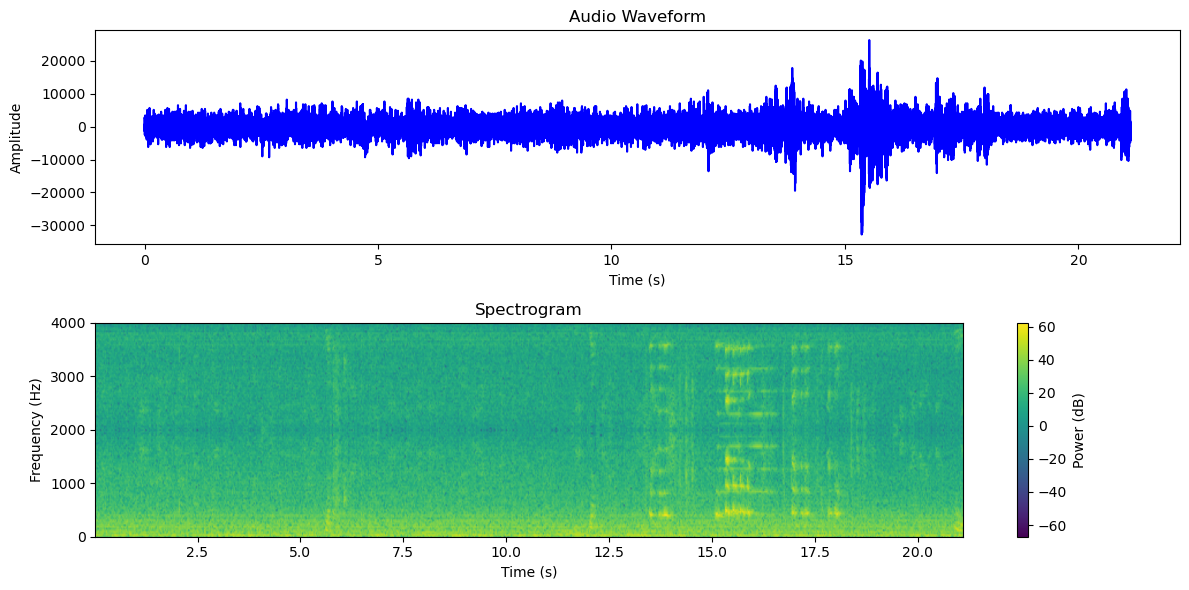

In [20]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np

# Function to plot waveform and spectrogram
def plot_waveform_and_spectrogram(stg_audio_data, sampling_rate=8000):
    """
    Plots the concatenated audio waveform and its spectrogram.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing 'audio_samples' column as lists of audio samples.
        sampling_rate (int): Sampling rate of the audio in Hz. Default is 8000 Hz.
    """
    # Concatenate all audio samples from all frames
    concatenated_audio = np.concatenate(stg_audio_data["audio_samples"].values)

    # Create a time array for the waveform
    time = np.linspace(0, len(concatenated_audio) / sampling_rate, len(concatenated_audio))

    # Create the spectrogram
    f, t, Sxx = spectrogram(concatenated_audio, fs=sampling_rate)

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, concatenated_audio, color='blue')
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot the spectrogram
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.colorbar(label="Power (dB)")
    plt.title("Spectrogram")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Assuming stg_audio_data is already loaded and contains the 'audio_samples' column
plot_waveform_and_spectrogram(stg_audio_data, sampling_rate=8000)

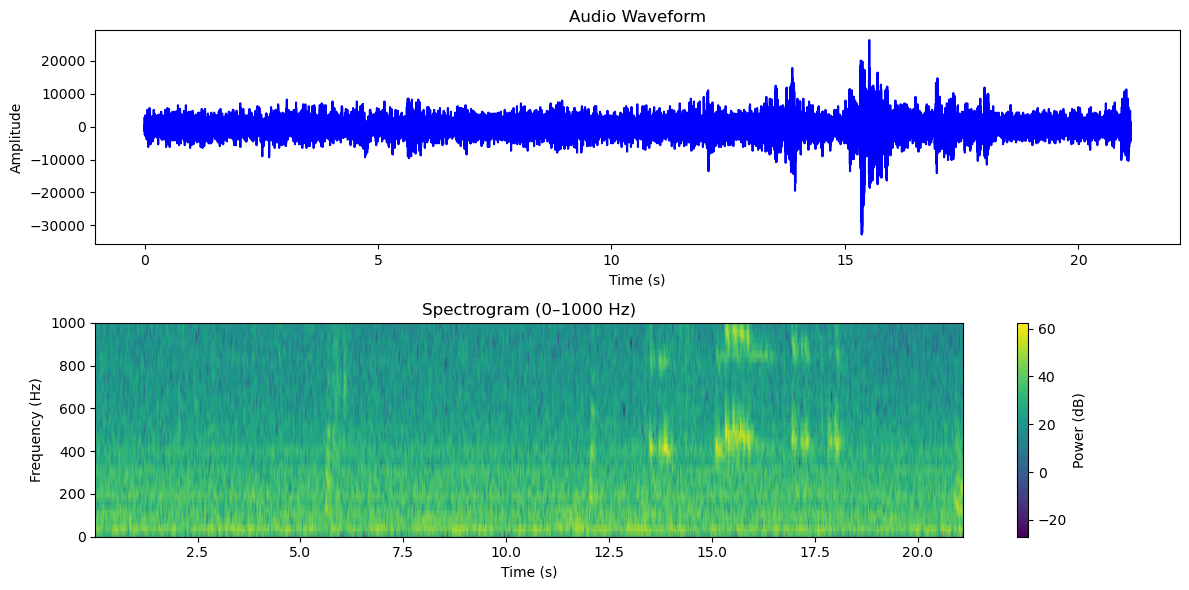

In [21]:
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import numpy as np

# Function to plot waveform and zoomed-in spectrogram (0–1000 Hz)
def plot_waveform_and_zoomed_spectrogram(stg_audio_data, sampling_rate=8000):
    """
    Plots the concatenated audio waveform and its spectrogram, zoomed in to 0–1000 Hz.

    Parameters:
        stg_audio_data (pd.DataFrame): DataFrame containing 'audio_samples' column as lists of audio samples.
        sampling_rate (int): Sampling rate of the audio in Hz. Default is 8000 Hz.
    """
    # Concatenate all audio samples from all frames
    concatenated_audio = np.concatenate(stg_audio_data["audio_samples"].values)

    # Create a time array for the waveform
    time = np.linspace(0, len(concatenated_audio) / sampling_rate, len(concatenated_audio))

    # Create the spectrogram
    f, t, Sxx = spectrogram(concatenated_audio, fs=sampling_rate)

    # Filter for frequencies up to 1000 Hz
    freq_limit = 1000
    freq_mask = f <= freq_limit
    f_zoomed = f[freq_mask]
    Sxx_zoomed = Sxx[freq_mask, :]

    # Plot the waveform
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time, concatenated_audio, color='blue')
    plt.title("Audio Waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

    # Plot the spectrogram zoomed in to 0–1000 Hz
    plt.subplot(2, 1, 2)
    plt.pcolormesh(t, f_zoomed, 10 * np.log10(Sxx_zoomed + 1e-10), shading='gouraud')
    plt.colorbar(label="Power (dB)")
    plt.title("Spectrogram (0–1000 Hz)")
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.tight_layout()
    plt.show()

# Assuming stg_audio_data is already loaded and contains the 'audio_samples' column
plot_waveform_and_zoomed_spectrogram(stg_audio_data, sampling_rate=8000)

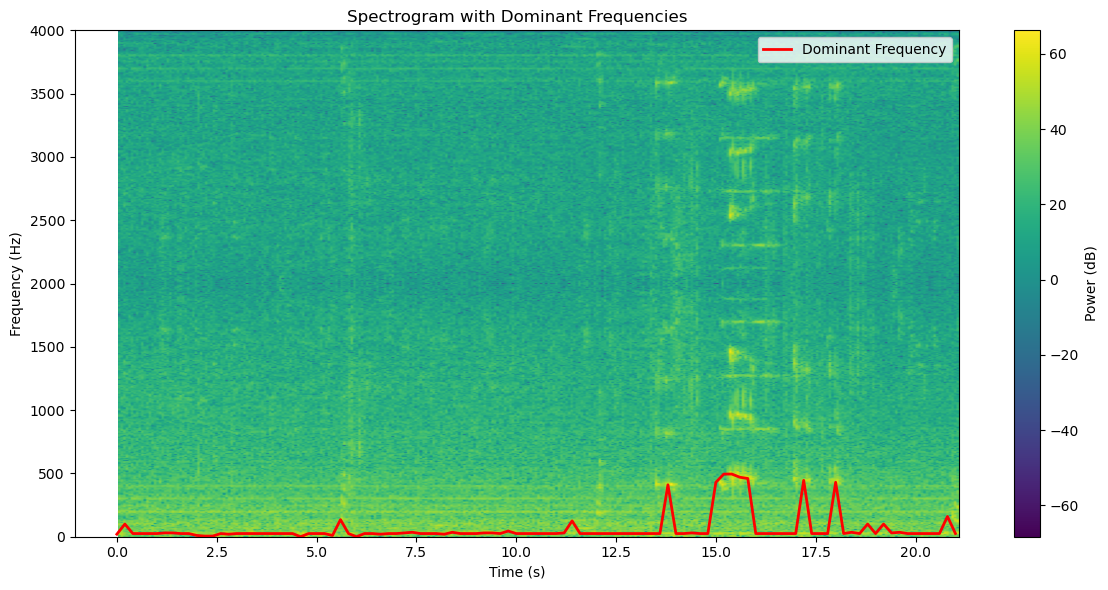

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming new_dataframe and stg_audio_data are already defined
# Extract necessary data
audio_samples = np.concatenate(stg_audio_data["audio_samples"].values)
timestamps = np.cumsum([0] + [len(samples) for samples in stg_audio_data["audio_samples"].values[:-1]]) / 8000  # Convert to seconds
dominant_frequencies = new_dataframe["dominant_frequency"]

# Create the spectrogram
sampling_rate = 8000  # Assuming audio is sampled at 8 kHz
plt.figure(figsize=(12, 6))
plt.specgram(audio_samples, Fs=sampling_rate, NFFT=1024, noverlap=512, cmap="viridis")
plt.colorbar(label="Power (dB)")
plt.title("Spectrogram with Dominant Frequencies")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

# Align dominant_frequencies with timestamps
dominant_timestamps = timestamps  # One timestamp per frame
plt.plot(dominant_timestamps, dominant_frequencies, color="red", label="Dominant Frequency", linewidth=2)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# IMU Transformations

In [24]:
stg_imu_data = pd.read_csv("stg_imu_data.csv")

In [25]:
# Convert samples column from string to list
stg_imu_data['yaw'] = stg_imu_data['yaw'].apply(ast.literal_eval)
stg_imu_data['pitch'] = stg_imu_data['pitch'].apply(ast.literal_eval)
stg_imu_data['roll'] = stg_imu_data['roll'].apply(ast.literal_eval)

In [26]:
stg_imu_data

,frame_id,timestamp,yaw,pitch,roll
0,0,2025-02-19 18:30:48.573551,"[0.04, 0.05, 0.03, 0.05]","[-0.15, 0.29, -0.12, 0.14]","[-0.09, 0.04, -0.17, 0.2]"
1,1,2025-02-19 18:30:48.744944,"[0.03, 0.04, 0.06, 0.03]","[0.49, 0.03, 0.3, 0.11]","[-0.1, -0.07, 0.29, -0.12]"
2,2,2025-02-19 18:30:48.918085,"[0.06, 0.03, 0.04, 0.04]","[0.01, 0.06, 0.51, 0.06]","[0.32, -0.13, -0.03, -0.1]"
3,3,2025-02-19 18:30:49.089371,"[0.05, 0.06, 0.04, 0.06]","[0.51, 0.13, 0.29, -0.03]","[-0.15, 0.09, -0.34, -0.02]"
4,4,2025-02-19 18:30:49.261106,"[0.08, 0.06, 0.06, 0.03]","[0.36, -0.04, 0.41, -0.04]","[0.22, 0.01, -0.08, -0.15]"
5,5,2025-02-19 18:30:49.432671,"[0.07, 0.03, 0.04, 0.05]","[-0.03, 0.11, -0.2, 0.23]","[0.31, -0.12, 0.2, 0.29]"
6,6,2025-02-19 18:30:49.607540,"[0.01, 0.05, 0.02, 0.05]","[0.14, 0.19, -0.02, 0.06]","[-0.17, 0.29, -0.11, 0.33]"
7,7,2025-02-19 18:30:49.777111,"[0.02, 0.04, 0.03, 0.02]","[-0.06, 0.25, -0.17, 0.28]","[-0.11, 0.22, 0.04, -0.04]"
8,8,2025-02-19 18:30:49.975406,"[0.05, 0.02, 0.0, 0.02]","[0.12, 0.37, -0.07, 0.26]","[0.38, -0.0, -0.11, 0.21]"
9,9,2025-02-19 18:30:50.121339,"[-0.01, 0.01, 0.0, 0.01]","[0.05, 0.36, -0.06, 0.39]","[-0.19, 0.15, -0.02, 0.07]"


In [27]:
def measure_time(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    return result, end - start

def extract_scalar(x):
    return x[0] if isinstance(x, list) else x

# --- Feature Functions ---

def unwrap_yaw(yaw_list):
    """
    Unwrap the yaw values (in degrees) using numpy.unwrap.
    Returns the unwrapped array.
    """
    arr = np.array(yaw_list, dtype=float)
    return np.degrees(np.unwrap(np.radians(arr)))

def avg_intra_yaw_diff(yaw_list):
    """
    For the given row's yaw (a list), unwrap it, compute the differences
    between consecutive values, and return the average difference.
    """
    unwrapped = unwrap_yaw(yaw_list)
    if len(unwrapped) > 1:
        diffs = np.diff(unwrapped)
        return np.mean(diffs)
    else:
        return 0.0

def compute_rotation_speed(current_yaw_list, prev_avg_yaw):
    """
    Compute rotation speed using only yaw.
      1. Compute the average intra-row yaw difference.
      2. Compute delta_yaw = current_avg - prev_avg (if available).
      3. Return absolute delta_yaw as the rotation speed, along with current_avg and raw delta.
    """
    current_avg = avg_intra_yaw_diff(current_yaw_list)
    if prev_avg_yaw is None:
        delta_yaw = 0.0
    else:
        delta_yaw = current_avg - prev_avg_yaw
    rotation_speed = abs(delta_yaw)
    return rotation_speed, current_avg, delta_yaw

def compute_movement_intensity(delta_yaw, delta_pitch, delta_roll):
    """
    Compute movement intensity as the Euclidean norm of (delta_yaw, delta_pitch, delta_roll).
    """
    return np.sqrt(delta_yaw**2 + delta_pitch**2 + delta_roll**2)

def compute_balance_state(pitch, roll, movement_intensity):
    """
    The robot is balanced if pitch and roll are within ±15° and movement_intensity is low (< 0.3).
    """
    return (abs(pitch) < 15) and (abs(roll) < 15) and (movement_intensity < 0.3)

def compute_cat_interaction(movement_intensity):
    """
    Flag a cat interaction if movement_intensity exceeds a certain value.
    """
    return abs(movement_intensity) > 10

def compute_is_rest(movement_intensity):
    """
    Mark as rest if movement_intensity is very low (< 1).
    """
    return movement_intensity < 1

In [28]:
# --- Live Processing Functions ---

def process_frame(row, state):
    """
    Process one IMU frame (one row) in live mode.
    Uses only previous frame values (stored in state) to compute differences.
    Each feature is computed by its own function.
    Returns a dict with all computed features.
    """
    # --- Rotation Speed (yaw only) ---
    rotation_speed, current_avg_yaw, delta_yaw = compute_rotation_speed(row['yaw'], state.get('prev_avg_yaw'))
    
    # --- Pitch and Roll differences ---
    # For pitch and roll, we assume they are already extracted as scalars.
    pitch = row['pitch']
    roll  = row['roll']
    if state.get('prev_pitch') is None:
        delta_pitch = 0.0
    else:
        delta_pitch = pitch - state['prev_pitch']
    if state.get('prev_roll') is None:
        delta_roll = 0.0
    else:
        delta_roll = roll - state['prev_roll']
    
    # --- Movement Intensity ---
    movement_intensity = compute_movement_intensity(delta_yaw, delta_pitch, delta_roll)
    
    # --- Balance State ---
    balance_state = compute_balance_state(pitch, roll, movement_intensity)
    
    # --- Cat Interaction ---
    cat_interaction_detected = compute_cat_interaction(movement_intensity)
    
    # --- is_rest Feature ---
    is_rest = compute_is_rest(movement_intensity)
    
    # --- Update state for live processing ---
    state['prev_avg_yaw'] = current_avg_yaw
    state['prev_pitch'] = pitch
    state['prev_roll'] = roll
    
    return {
        'frame_id': row['frame_id'],
        'timestamp': row['timestamp'],
        'rotation_speed': rotation_speed,
        'movement_intensity': movement_intensity,
        'balance_state': balance_state,
        'cat_interaction_detected': cat_interaction_detected,
        'is_rest': is_rest,
        # Optionally, include deltas for debugging/tuning:
        'delta_yaw': delta_yaw,
        'delta_pitch': delta_pitch,
        'delta_roll': delta_roll
    }

def process_imu_live(imu_df):
    """
    Process the entire IMU DataFrame row by row (live data simulation)
    and return a transformed table with computed features.
    """
    state = {'prev_avg_yaw': None, 'prev_pitch': None, 'prev_roll': None}
    results = []
    for _, row in imu_df.iterrows():
        features = process_frame(row, state)
        results.append(features)
    return pd.DataFrame(results)

In [29]:
# --- Main Processing Cell ---

# Prepare and clean IMU data.
# (Assumes your pre-cells have done the following:
# 1. stg_imu_data = pd.read_csv("stg_imu_data.csv")
# 2. Converting 'yaw', 'pitch', 'roll' from string to list.
# 3. For pitch and roll, extracting the first element; leave yaw as the full list.)
imu_df = stg_imu_data[['frame_id', 'timestamp', 'yaw', 'pitch', 'roll']].copy()
imu_df['pitch'] = imu_df['pitch'].apply(lambda x: x[0] if isinstance(x, list) else x)
imu_df['roll']  = imu_df['roll'].apply(lambda x: x[0] if isinstance(x, list) else x)
# Do NOT extract yaw (we need the full list for intra-row processing).

# Process the IMU data live and obtain the mart table.
trans_imu_features = process_imu_live(imu_df)

# Optionally, inspect the transformed table.
print(trans_imu_features.describe())

         frame_id  rotation_speed  movement_intensity   delta_yaw  \
count  117.000000      117.000000          117.000000  117.000000   
mean    58.000000        0.404473            1.974541   -0.000028   
std     33.919021        1.009024            3.073727    1.087722   
min      0.000000        0.000000            0.000000   -4.026667   
25%     29.000000        0.006667            0.280357   -0.013333   
50%     58.000000        0.013333            0.601424    0.000000   
75%     87.000000        0.180000            1.970812    0.010000   
max    116.000000        6.320000           19.667492    6.320000   

       delta_pitch  delta_roll  
count   117.000000  117.000000  
mean     -0.002051    0.002735  
std       2.053089    2.825225  
min     -11.800000   -9.410000  
25%      -0.430000   -0.600000  
50%      -0.020000   -0.060000  
75%       0.300000    0.230000  
max       6.500000   18.360000  


In [30]:
trans_imu_features

,frame_id,timestamp,rotation_speed,movement_intensity,balance_state,cat_interaction_detected,is_rest,delta_yaw,delta_pitch,delta_roll
0,0,2025-02-19 18:30:48.573551,0.000000e+00,0.000000,True,False,True,0.000000e+00,0.00,0.00
1,1,2025-02-19 18:30:48.744944,3.333333e-03,0.640087,False,False,True,-3.333333e-03,0.64,-0.01
2,2,2025-02-19 18:30:48.918085,6.666667e-03,0.637844,False,False,True,-6.666667e-03,-0.48,0.42
3,3,2025-02-19 18:30:49.089371,1.000000e-02,0.686294,False,False,True,1.000000e-02,0.50,-0.47
4,4,2025-02-19 18:30:49.261106,2.000000e-02,0.399750,False,False,True,-2.000000e-02,-0.15,0.37
5,5,2025-02-19 18:30:49.432671,1.000000e-02,0.400375,False,False,True,1.000000e-02,-0.39,0.09
6,6,2025-02-19 18:30:49.607540,2.000000e-02,0.509608,False,False,True,2.000000e-02,0.17,-0.48
7,7,2025-02-19 18:30:49.777111,1.333333e-02,0.209231,True,False,True,-1.333333e-02,-0.20,0.06
8,8,2025-02-19 18:30:49.975406,1.000000e-02,0.522111,False,False,True,-1.000000e-02,0.18,0.49
9,9,2025-02-19 18:30:50.121339,1.666667e-02,0.574524,False,False,True,1.666667e-02,-0.07,-0.57


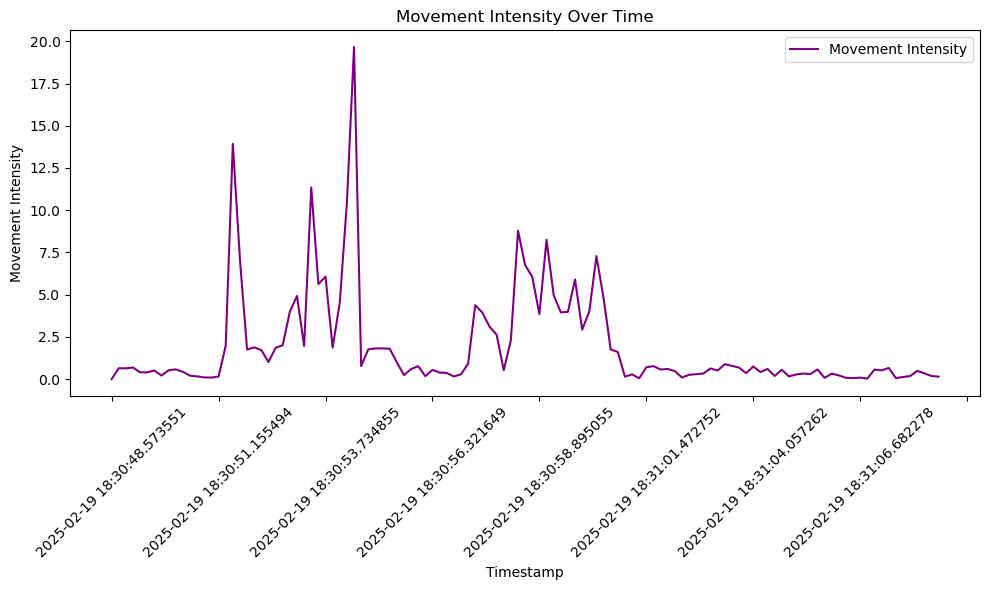

In [31]:


plt.figure(figsize=(10, 6))
plt.plot(trans_imu_features['timestamp'], trans_imu_features['movement_intensity'],
         label='Movement Intensity', color='purple')
plt.title('Movement Intensity Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Movement Intensity')
plt.legend()

# Rotate timestamps to avoid overlap
plt.xticks(rotation=45)

# Optionally limit the number of x-axis ticks to reduce clutter
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(10))

plt.tight_layout()
plt.show()

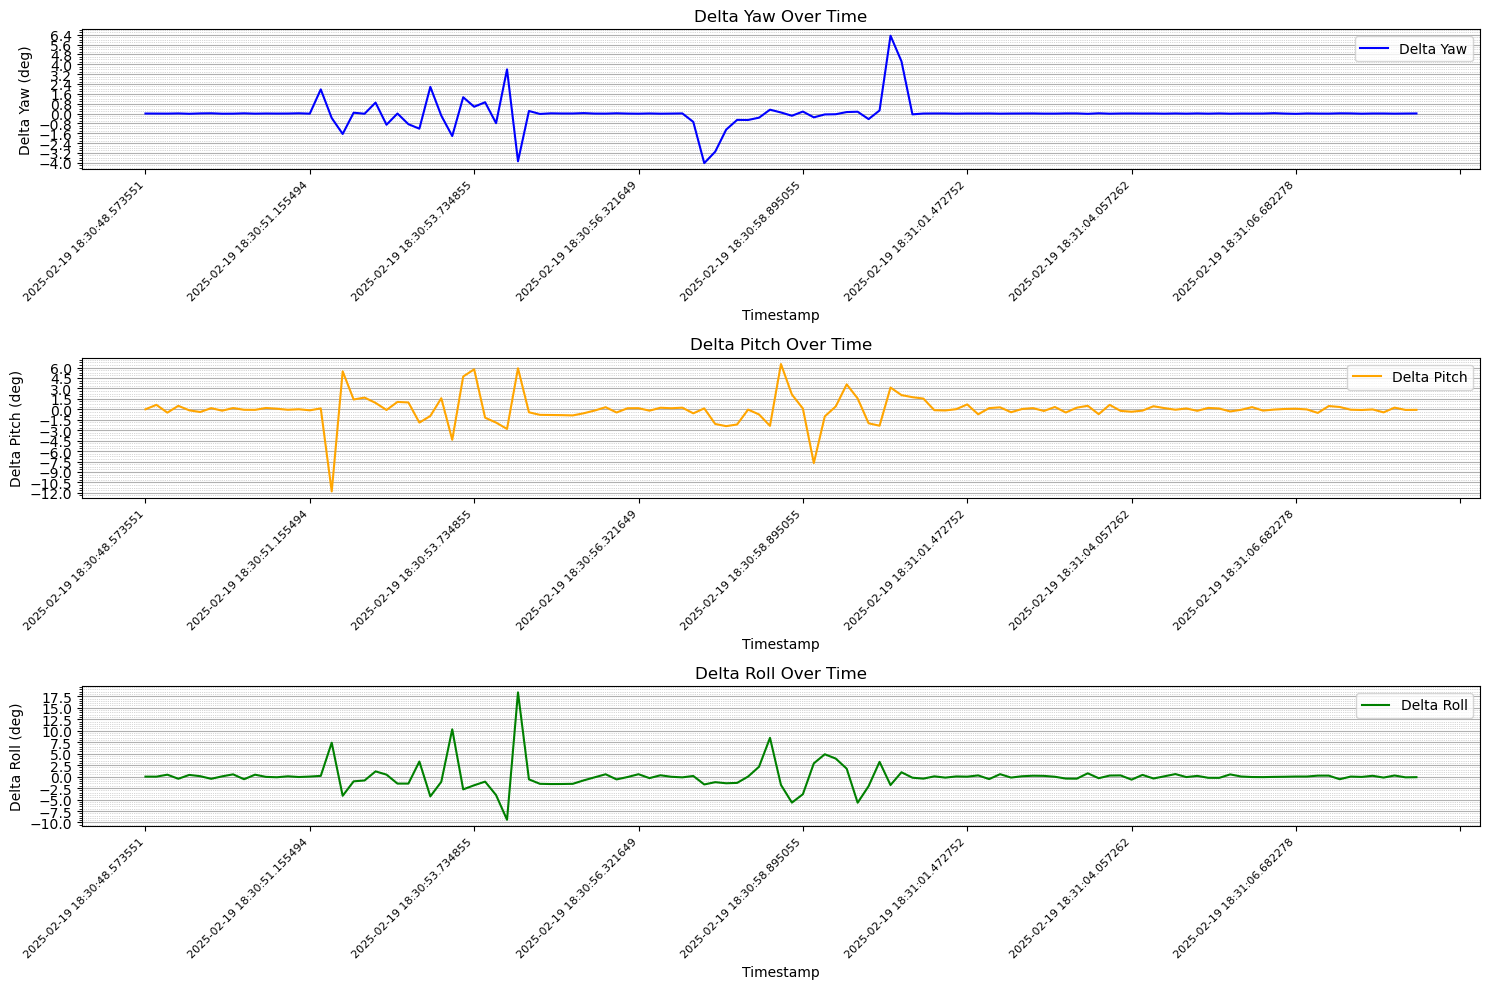

In [32]:
plt.figure(figsize=(15, 10))

# --- Subplot 1: Delta Yaw ---
ax1 = plt.subplot(3, 1, 1)
ax1.plot(trans_imu_features['timestamp'], trans_imu_features['delta_yaw'], 
         label='Delta Yaw', color='blue')
ax1.set_title('Delta Yaw Over Time')
ax1.set_xlabel('Timestamp')
ax1.set_ylabel('Delta Yaw (deg)')
ax1.legend()

# Increase the number of major ticks on Y
ax1.yaxis.set_major_locator(ticker.MaxNLocator(15))
# Enable minor ticks automatically
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())
# Show grid lines for both major and minor ticks
ax1.grid(which='major', axis='y', linewidth=0.8)
ax1.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)

# Limit the number of X ticks to reduce clutter
ax1.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# --- Subplot 2: Delta Pitch ---
ax2 = plt.subplot(3, 1, 2)
ax2.plot(trans_imu_features['timestamp'], trans_imu_features['delta_pitch'], 
         label='Delta Pitch', color='orange')
ax2.set_title('Delta Pitch Over Time')
ax2.set_xlabel('Timestamp')
ax2.set_ylabel('Delta Pitch (deg)')
ax2.legend()

ax2.yaxis.set_major_locator(ticker.MaxNLocator(15))
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.grid(which='major', axis='y', linewidth=0.8)
ax2.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)

ax2.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=8)

# --- Subplot 3: Delta Roll ---
ax3 = plt.subplot(3, 1, 3)
ax3.plot(trans_imu_features['timestamp'], trans_imu_features['delta_roll'], 
         label='Delta Roll', color='green')
ax3.set_title('Delta Roll Over Time')
ax3.set_xlabel('Timestamp')
ax3.set_ylabel('Delta Roll (deg)')
ax3.legend()

ax3.yaxis.set_major_locator(ticker.MaxNLocator(15))
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.grid(which='major', axis='y', linewidth=0.8)
ax3.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)

ax3.xaxis.set_major_locator(ticker.MaxNLocator(10))
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

# Video Transformations

In [123]:
import torch
import numpy as np
import pandas as pd
import ast
from PIL import Image

In [125]:
stg_video_data = pd.read_csv("stg_visual_data.csv")

In [127]:
stg_video_data.head()

,frame_id,timestamp,frame_data
0,0,2025-03-08 19:27:45.300599,"[152, 156, 163, 170, 179, 190, 202, 209, 227, ..."
1,1,2025-03-08 19:27:45.498228,"[148, 153, 160, 169, 177, 188, 198, 205, 224, ..."
2,2,2025-03-08 19:27:45.698362,"[149, 153, 160, 170, 181, 192, 201, 206, 221, ..."
3,3,2025-03-08 19:27:45.899458,"[151, 156, 163, 171, 180, 190, 201, 208, 223, ..."
4,4,2025-03-08 19:27:46.096461,"[150, 155, 163, 171, 180, 191, 202, 209, 226, ..."


In [167]:
# 1) Load the YOLOv5 model (ensure you've installed torch + ultralytics)
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
model.conf = 0.3  # Confidence threshold

Using cache found in /Users/asaphbrosh/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-3-18 Python-3.11.7 torch-2.2.2 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [169]:
def detect_cat_in_stg_video_data(stg_video_data):
    """
    Takes stg_video_data (with columns: frame_id, timestamp, frame_data)
    where frame_data can be either a list of length 96*96 or a string representation
    of such a list. Runs YOLOv5 inference, and returns a new DataFrame with:
      - frame_id
      - timestamp
      - is_cat_detected (0 or 1)
      - cat_confidence (float)
      - inference_time (float)  # how many seconds this frame took
      - raw_detection (list of dicts): the full YOLO detection results per frame

    Additionally:
      - Prints total processing time for all frames
      - Prints average time per frame
    """

    total_start = time.time()
    results_list = []

    for _, row in stg_video_data.iterrows():
        frame_id = row["frame_id"]
        timestamp = row["timestamp"]
        raw_pixels = row["frame_data"]

        # If raw_pixels is a string like "[152, 156, ...]", parse it
        if isinstance(raw_pixels, str):
            raw_pixels = ast.literal_eval(raw_pixels)

        # Convert to numpy array (uint8) and reshape into 96x96 grayscale image
        image_2d = np.array(raw_pixels, dtype=np.uint8).reshape(96, 96)

        # Convert to PIL Image (grayscale)
        pil_img = Image.fromarray(image_2d, mode='L')

        # Start timing for this individual frame
        frame_start = time.time()

        # Run YOLOv5 inference
        detection = model(pil_img)

        frame_end = time.time()
        inference_time = frame_end - frame_start

        # Default: no cat found
        is_cat_detected = 0
        cat_confidence = 0.0

        # Convert results to a pandas DataFrame
        det_df = detection.pandas().xyxy[0]  # columns: [xmin, ymin, xmax, ymax, confidence, class, name]
        
        # Convert the entire detection dataframe to a list of dicts
        # so you can see *all* bounding boxes, classes, and confidences
        raw_detection = det_df.to_dict(orient='records')

        # Filter rows for 'cat'
        cat_rows = det_df[det_df['name'] == 'cat']
        if not cat_rows.empty:
            is_cat_detected = 1
            cat_confidence = float(cat_rows['confidence'].max())

        results_list.append({
            "frame_id": frame_id,
            "timestamp": timestamp,
            "is_cat_detected": is_cat_detected,
            "cat_confidence": cat_confidence,
            "inference_time": inference_time,
            "raw_detection": raw_detection
        })

    total_end = time.time()
    total_time = total_end - total_start
    num_frames = len(stg_video_data)

    print(f"Processed {num_frames} frames in {total_time:.2f} seconds")
    print(f"Average time per frame: {total_time / num_frames:.2f} seconds")

    return pd.DataFrame(results_list)

In [171]:
# 2) Use the function on your staging video data
#    stg_video_data: DataFrame with 'frame_id', 'timestamp', 'frame_data' columns
trans_visual_cat_detection = detect_cat_in_stg_video_data(stg_video_data)

Processed 99 frames in 11.82 seconds
Average time per frame: 0.12 seconds


In [172]:
# 3) Inspect the resulting DataFrame
trans_visual_cat_detection

,frame_id,timestamp,is_cat_detected,cat_confidence,inference_time,raw_detection
0,0,2025-03-08 19:27:45.300599,0,0.0,0.091321,[]
1,1,2025-03-08 19:27:45.498228,0,0.0,0.095055,[]
2,2,2025-03-08 19:27:45.698362,0,0.0,0.097464,[]
3,3,2025-03-08 19:27:45.899458,0,0.0,0.085383,[]
4,4,2025-03-08 19:27:46.096461,0,0.0,0.105653,[]
5,5,2025-03-08 19:27:46.296129,0,0.0,0.093085,[]
6,6,2025-03-08 19:27:46.499531,0,0.0,0.120399,[]
7,7,2025-03-08 19:27:46.697890,0,0.0,0.108480,[]
8,8,2025-03-08 19:27:46.898214,0,0.0,0.107800,[]
9,9,2025-03-08 19:27:47.097837,0,0.0,0.109847,[]


In [199]:
import torch
import numpy as np
from PIL import Image, ImageDraw, ImageFont

def detect_objects_in_array(raw_pixels, yolo_model, height=96, width=96, channels=1):
    """
    Given a single array of pixel data (e.g., grayscale or color), this function:
      1) Reshapes and converts the array into a PIL image.
      2) Runs YOLO object detection.
      3) Draws the detection boxes on the image.
      4) Returns the annotated PIL image.

    Args:
        raw_pixels (list or np.array): Raw pixel data, length should be height*width*(channels).
        yolo_model: A YOLO model loaded via torch.hub or ultralytics.
        height (int): Image height, default 96.
        width (int): Image width, default 96.
        channels (int): Number of channels in the raw data (1 for grayscale, 3 for RGB, etc.).

    Returns:
        PIL.Image: The annotated image with bounding boxes drawn.
    """
    # 1) Convert raw pixel data into a NumPy array with shape (height, width[, channels])
    arr = np.array(raw_pixels, dtype=np.uint8)
    if channels == 1:
        # shape will be (height, width)
        arr_2d = arr.reshape(height, width)
        # YOLO typically expects 3-channel color, so replicate the single channel
        arr_3ch = np.stack((arr_2d, arr_2d, arr_2d), axis=-1)
    else:
        # shape will be (height, width, channels)
        arr_3ch = arr.reshape(height, width, channels)
        # If channels == 3 already, we assume it's color.

    # 2) Convert to PIL image
    pil_img = Image.fromarray(arr_3ch)

    # 3) Run YOLO inference
    #    YOLO can auto-letterbox to the correct size internally.
    #    'size=640' is a typical default, you can adjust as needed.
    results = yolo_model(pil_img, size=640)
    dets = results.xyxy[0].cpu().numpy()  # shape (N, 6) -> [x1, y1, x2, y2, conf, cls]

    # If your YOLO model has 'model.names' for class labels
    class_names = getattr(yolo_model, 'names', {})

    # 4) Draw bounding boxes
    draw = ImageDraw.Draw(pil_img)
    font = ImageFont.load_default()
    for *box, conf, cls_idx in dets:
        x1, y1, x2, y2 = box
        label = class_names.get(int(cls_idx), str(int(cls_idx)))
        # Draw the rectangle
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        text = f"{label} {conf:.2f}"
        # Create a background for the text
        text_w, text_h = draw.textsize(text, font=font)
        draw.rectangle([x1, y1 - text_h, x1 + text_w, y1], fill="red")
        draw.text((x1, y1 - text_h), text, fill="white", font=font)

    # Return the annotated PIL image
    return pil_img

In [207]:
# Example usage:
# import matplotlib.pyplot as plt
# yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)
raw_pixels = stg_video_data['frame_data'][10]
annotated_img = detect_objects_in_array(raw_pixels, model, height=96, width=96, channels=1)
plt.imshow(annotated_img)
plt.axis('off')
plt.show()

ValueError: invalid literal for int() with base 10: '[149, 154, 163, 172, 181, 192, 202, 208, 228, 236, 245, 248, 248, 248, 247, 247, 248, 248, 248, 247, 245, 243, 239, 236, 212, 206, 196, 187, 180, 172, 164, 159, 152, 150, 146, 143, 139, 137, 135, 134